In [1]:
import pickle as pkl
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras.layers import *
import keras.backend as K
from keras.backend import int_shape
import tensorflow_addons as tfa

In [2]:
#Import training data from results folder
savepath = './results/'
trainin = pkl.load(open(savepath + "trainin", "rb"))
trainout = pkl.load(open(savepath + "trainout", "rb"))
testin = pkl.load(open(savepath + "realdatain", "rb"))
testout = pkl.load(open(savepath + "realdataout_s", "rb"))

In [3]:
#Checking shapes of input data. Should be like (Number of samples, Number of features)
print(trainin.shape)
print(trainout.shape)
print(testin.shape)
print(testout.shape)

(37500, 2401)
(37500, 1)
(364, 2401)
(364, 1)


In [4]:
#Remove outliers 1.5 times greater than third quartile or less than first quartile of all pixel brightness
def RemoveOutliers(inputs):
    quants = tfp.stats.quantiles(inputs, num_quantiles=4)
    iqr = quants[3] - quants[1]
    upper = quants[3] + K.constant(1.5) * iqr
    lower = quants[1] - K.constant(1.5) * iqr
    zeros = K.zeros_like(inputs)
    outputs = K.switch(K.greater(inputs, upper), zeros, inputs)
    outputs = K.switch(K.less(inputs, lower), zeros, outputs)
    
    return outputs

In [5]:
#Normalization of all pixels across a batch
def NormalizeBatch(inputs):
    mean = tf.math.reduce_mean(inputs)
    stdv = tf.math.reduce_std(inputs)
    
    return (inputs-mean)/stdv

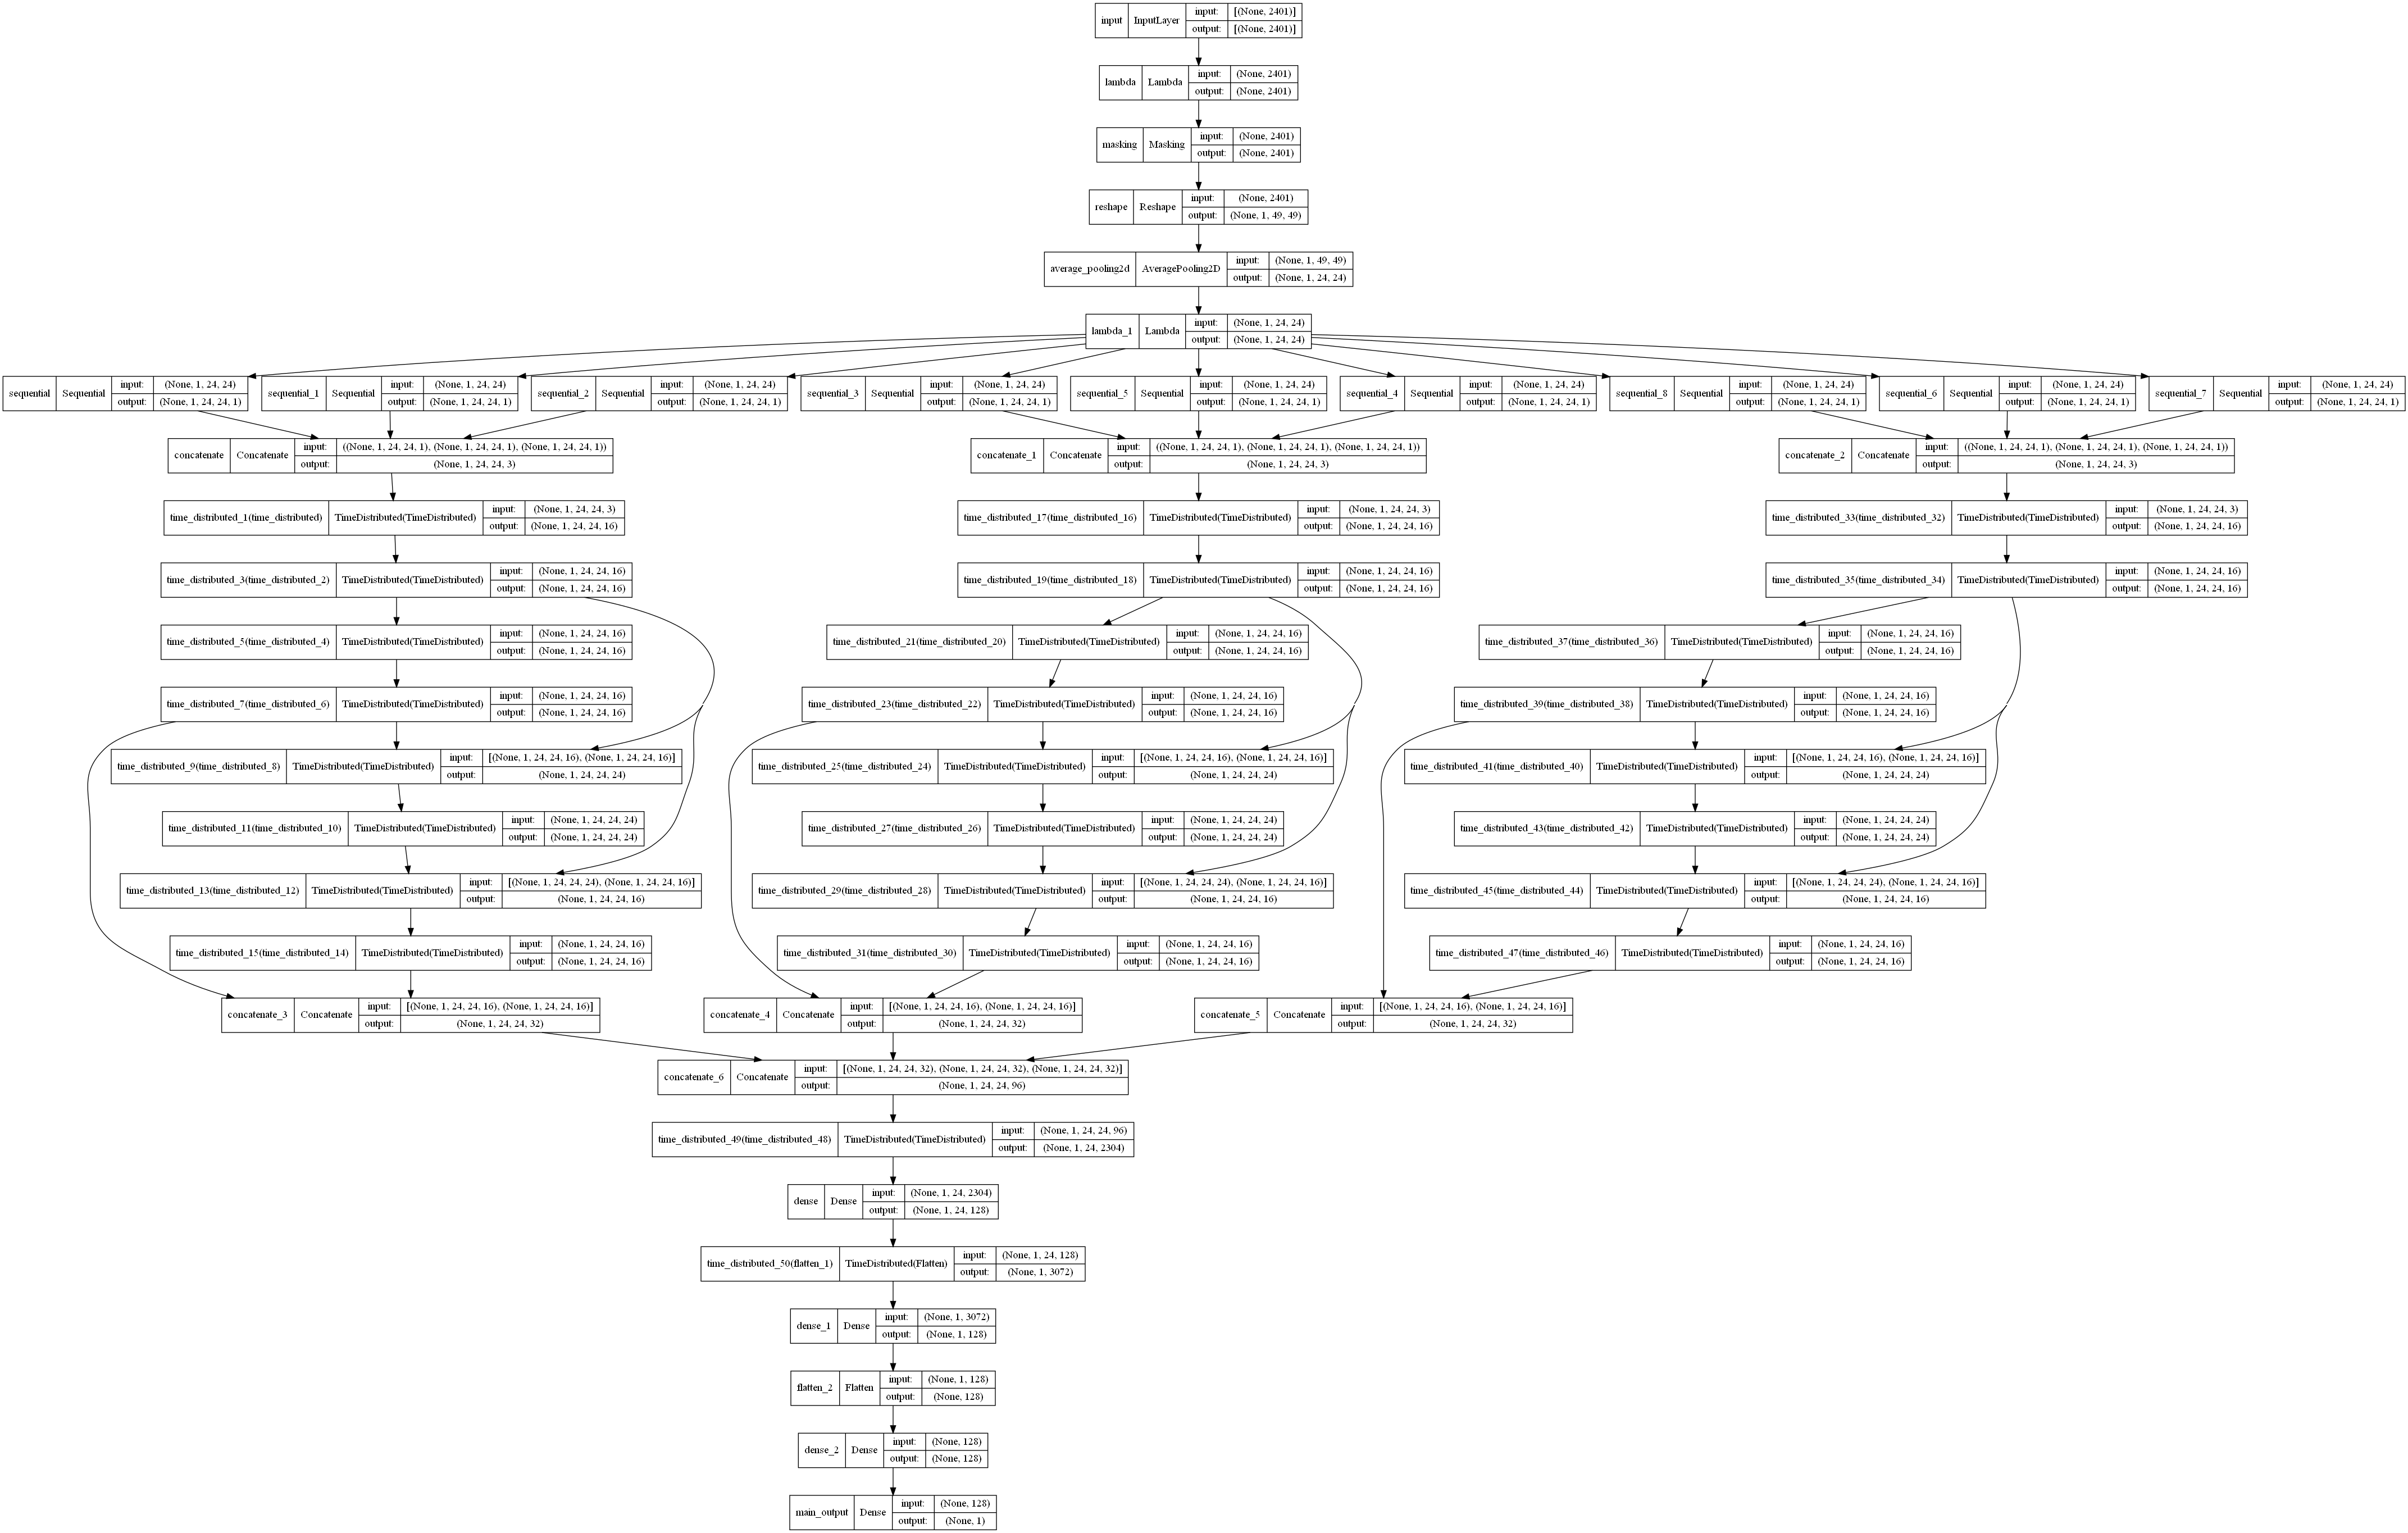

In [6]:
#Input and output sizes
input_size = trainin.shape[1] #Input dimensions to model
output_size = trainout.shape[1] #Output dimensions to model

#ML Hyperparameters
lr = 10e-4 #learning rate
epochs = 8 #number of passes of the data
batchsize = 1 #number of images fed in at a time
version = 2 #model version number if same hyperparameters
iterations = trainin.shape[0]//batchsize #number of batches used per epoch
lr_decay = (1./0.98 -1)/(len(testin)/batchsize) #learning rate decay
optimizer = tf.keras.optimizers.Adam(epsilon=1e-2, decay=lr_decay) #ML optimizer

metric =  keras.metrics.MeanSquaredError() #metric to be used for training
val_metric = keras.metrics.MeanSquaredError() #metric to be used for validation

#Configuration dictionary for ML model
config = {'act1': 'relu', 'act2': 'linear', 'act3': 'softmax'}

#Layer Dimensions
lstm_size = 8 #Number of lstm nodes in seq2seq block
conv_size = 8 #Number of convolutional layers at the start of each conv block
final_size = 1 #Number of output layers in conv block (Increasing this exponentially scales processing time)
dense_size = 128 #Number of dense layers at the end of the model unrolling the key features

#Convolutional block made up of three sub-blocks concatenated according to "order"
def ConvBlock(inputs, order):
    ConvBlock1 = keras.Sequential()
    ConvBlock1.add(Conv2D(conv_size, 
                          kernel_size=2, 
                          padding='same', 
                          data_format='channels_first', 
                          activation=config['act1']))
    ConvBlock1.add(BatchNormalization())
    ConvBlock1.add(Conv2D(final_size, 
                          kernel_size=2, 
                          padding='same', 
                          data_format='channels_first', 
                          activation=config['act1']))
    ConvBlock1.add(SpatialDropout2D(0.4, data_format='channels_first'))
    ConvBlock1.add(tfa.layers.InstanceNormalization())
    ConvBlock1.add(Reshape((final_size, 24, 24, 1)))
    
    ConvBlock2 = keras.Sequential()
    ConvBlock2.add(Conv2D(conv_size, 
                          kernel_size=3, 
                          padding='same', 
                          data_format='channels_first', 
                          activation=config['act1']))
    ConvBlock2.add(BatchNormalization())
    ConvBlock2.add(Conv2D(final_size, 
                          kernel_size=3, 
                          padding='same', 
                          data_format='channels_first',
                          activation=config['act1']))
    ConvBlock2.add(SpatialDropout2D(0.4, data_format='channels_first'))
    ConvBlock2.add(tfa.layers.InstanceNormalization())
    ConvBlock2.add(Reshape((final_size, 24, 24, 1)))
    
    ConvBlock3 = keras.Sequential()
    ConvBlock3.add(Conv2D(conv_size, 
                          kernel_size=5, 
                          padding='same', 
                          data_format='channels_first', 
                          activation=config['act1']))
    ConvBlock3.add(BatchNormalization())
    ConvBlock3.add(Conv2D(final_size, 
                          kernel_size=5, 
                          padding='same', 
                          data_format='channels_first', 
                          activation=config['act1']))
    ConvBlock3.add(SpatialDropout2D(0.4, data_format='channels_first'))
    ConvBlock3.add(tfa.layers.InstanceNormalization())
    ConvBlock3.add(Reshape((final_size, 24, 24, 1)))
    
    if order==1:
        ConvBlock = Concatenate(axis=4)((ConvBlock1(inputs), ConvBlock2(inputs), ConvBlock3(inputs)))
    elif order==2:
        ConvBlock = Concatenate(axis=4)((ConvBlock1(inputs), ConvBlock3(inputs), ConvBlock2(inputs)))
    elif order==3:
        ConvBlock = Concatenate(axis=4)((ConvBlock3(inputs), ConvBlock1(inputs), ConvBlock2(inputs)))
    return ConvBlock

inputs = keras.Input(shape=(input_size,), name='input') #Input layer
x = Lambda(RemoveOutliers)(inputs) #Lambda layer calling setting outlier values to 0
x = Masking(mask_value=0.0)(x) #Masking values equal to 0
x = Reshape(target_shape=(1, 49, 49))(x) #Reshaping to add a channel dimension before the features
x = AveragePooling2D(data_format='channels_first')(x) #Averaging adjacent pixels to reduce number of significant features
x = Lambda(NormalizeBatch)(x) #Normalizing all items in batch (Not using batchnorm because we want this to work the same for training and testing)

#Creating covolutional block layers with each permutation of the sub-block order
conv1 = ConvBlock(x, 1)
conv2 = ConvBlock(x, 2)
conv3 = ConvBlock(x, 3)

#The first Seq2Seq block with attention wrapped in two time-distributed layers. 
#Inputs to the model will look like (columns, convolutional sub-blocks)
x = TimeDistributed(TimeDistributed(Bidirectional(LSTM(lstm_size, #Number of BLSTM nodes
                                                       activation=config['act1'], #Activation function
                                                       recurrent_dropout=0.4, #Occasionally forget relationship between memory cells during training
                                                       dropout=0.4, #Occasionally forget memory cells during training
                                                       return_sequences=True, #Will pass all lstm sequences to next LSTM layer
                                                       return_state=False))))(conv1)
x = TimeDistributed(TimeDistributed(BatchNormalization()))(x)
y = TimeDistributed(TimeDistributed(Bidirectional(LSTM(lstm_size, 
                                                       activation=config['act1'], 
                                                       recurrent_dropout=0.4, 
                                                       dropout=0.4, 
                                                       return_sequences=True))))(x)
y = TimeDistributed(TimeDistributed(BatchNormalization()))(y) #Batch normalize the convolutional filters for each column
attention = TimeDistributed(TimeDistributed(Dot(axes=[2, 2])))([y, x]) #Dot product attention mechanism creates weighting of features
attention = TimeDistributed(TimeDistributed(Activation(config['act3'])))(attention)
context = TimeDistributed(TimeDistributed(Dot(axes=[2, 1])))([attention, x])
context = TimeDistributed(TimeDistributed(BatchNormalization()))(context)
dcc1 = Concatenate()([context, y])

x = TimeDistributed(TimeDistributed(Bidirectional(LSTM(lstm_size, activation=config['act1'], recurrent_dropout=0.4, dropout=0.4, return_sequences=True, return_state=False))))(conv2)
x = TimeDistributed(TimeDistributed(BatchNormalization()))(x)
y = TimeDistributed(TimeDistributed(Bidirectional(LSTM(lstm_size, activation=config['act1'], recurrent_dropout=0.4, dropout=0.4, return_sequences=True))))(x)
y = TimeDistributed(TimeDistributed(BatchNormalization()))(y)
attention = TimeDistributed(TimeDistributed(Dot(axes=[2, 2])))([y, x])
attention = TimeDistributed(TimeDistributed(Activation(config['act3'])))(attention)
context = TimeDistributed(TimeDistributed(Dot(axes=[2, 1])))([attention, x])
context = TimeDistributed(TimeDistributed(BatchNormalization()))(context)
dcc2 = Concatenate()([context, y])

x = TimeDistributed(TimeDistributed(Bidirectional(LSTM(lstm_size, activation=config['act1'], recurrent_dropout=0.4, dropout=0.4, return_sequences=True, return_state=False))))(conv3)
x = TimeDistributed(TimeDistributed(BatchNormalization()))(x)
y = TimeDistributed(TimeDistributed(Bidirectional(LSTM(lstm_size, activation=config['act1'], recurrent_dropout=0.4, dropout=0.4, return_sequences=True))))(x)
y = TimeDistributed(TimeDistributed(BatchNormalization()))(y)
attention = TimeDistributed(TimeDistributed(Dot(axes=[2, 2])))([y, x])
attention = TimeDistributed(TimeDistributed(Activation(config['act3'])))(attention)
context = TimeDistributed(TimeDistributed(Dot(axes=[2, 1])))([attention, x])
context = TimeDistributed(TimeDistributed(BatchNormalization()))(context)
dcc3 = Concatenate()([context, y])

decoder_combined_context = Concatenate()([dcc1, dcc2, dcc3]) #Concatenate Seq2Seq block outputs

#Fully connected block that gradually unrolls Columns -> Rows -> Convolutional filter nodes
y = TimeDistributed(TimeDistributed(Flatten()))(decoder_combined_context)
y = Dense(dense_size, activation=config['act1'])(y)
y = TimeDistributed(Flatten())(y)
y = Dense(dense_size, activation=config['act1'])(y)
y = Flatten()(y)
y = Dense(dense_size, activation=config['act1'])(y)

main_output = Dense(output_size, activation=config['act2'], name='main_output')(y)#Output layer

#Assemble model
model = keras.Model(inputs=inputs, outputs = main_output)
modelname = ("GatedCNN_%.1e_%d_%d_%d" % (lr, epochs, batchsize, version))
#PNG image of model structure
keras.utils.plot_model(model, 'GatedCNN.png', show_shapes=True)

In [7]:
#Compile model
model.compile(optimizer=optimizer,
              loss='mse',
              metrics='mae'
            )

In [8]:
#Train the model
model.fit(trainin, 
          trainout, 
          batch_size=batchsize, 
          epochs=epochs, 
          verbose=1, 
          validation_data=(testin, testout),
          steps_per_epoch=3750,
         )

Epoch 1/8
3750/3750 [==============================] - 993s 258ms/step - loss: 0.1444 - mae: 0.2649 - val_loss: 0.1066 - val_mae: 0.2669
Epoch 2/8
3750/3750 [==============================] - 933s 249ms/step - loss: 0.0372 - mae: 0.1482 - val_loss: 0.1493 - val_mae: 0.2835
Epoch 3/8
3750/3750 [==============================] - 937s 250ms/step - loss: 0.0240 - mae: 0.1195 - val_loss: 0.0823 - val_mae: 0.2178
Epoch 4/8
3750/3750 [==============================] - 935s 249ms/step - loss: 0.0193 - mae: 0.1082 - val_loss: 0.0644 - val_mae: 0.1997
Epoch 5/8
3750/3750 [==============================] - 935s 249ms/step - loss: 0.0209 - mae: 0.1075 - val_loss: 0.0732 - val_mae: 0.2040
Epoch 6/8
3750/3750 [==============================] - 935s 249ms/step - loss: 0.0144 - mae: 0.0931 - val_loss: 0.0631 - val_mae: 0.1954
Epoch 7/8
3750/3750 [==============================] - 934s 249ms/step - loss: 0.0149 - mae: 0.0928 - val_loss: 0.0612 - val_mae: 0.1966
Epoch 8/8
3750/3750 [====================

In [9]:
#Save the model
model.save("./results/%s.h5" % (modelname))